In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import gc
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.activations import relu, elu, linear
from keras import backend as K
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12

2.0.0


# Tensorflow Neural Network on WHR Data

In [2]:
data_pd = pd.read_pickle("../data/world_happiness.pickle")
data = data_pd.to_numpy()[:,2:]; data_pd

,Country,Happiness Rank,Happiness,Economy,Family,Health,Freedom,Trust,Generosity
0,Switzerland_2015,1,7.587,1.396510,1.349510,0.941430,0.665570,0.419780,0.296780
1,Iceland_2015,2,7.561,1.302320,1.402230,0.947840,0.628770,0.141450,0.436300
2,Denmark_2015,3,7.527,1.325480,1.360580,0.874640,0.649380,0.483570,0.341390
3,Norway_2015,4,7.522,1.459000,1.330950,0.885210,0.669730,0.365030,0.346990
4,Canada_2015,5,7.427,1.326290,1.322610,0.905630,0.632970,0.329570,0.458110
...,...,...,...,...,...,...,...,...,...
465,Rwanda_2017,151,3.471,0.368746,0.945707,0.326425,0.581844,0.455220,0.252756
466,Syria_2017,152,3.462,0.777153,0.396103,0.500533,0.081539,0.151347,0.493664
467,Tanzania_2017,153,3.349,0.511136,1.041990,0.364509,0.390018,0.066035,0.354256
468,Burundi_2017,154,2.905,0.091623,0.629794,0.151611,0.059901,0.084148,0.204435


In [3]:
input_data = data[:,1:]
output_data = data[:,0]
nr_params = input_data.shape[1]; nr_datapoints = input_data.shape[0]; nr_params, nr_datapoints

(6, 470)

In [4]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

# Hyperparameter Optimization

In [5]:
all_params = {
    "hidden_layers" : [1, 2, 4],
    "neurons" : [2, 4, 8],
    "epochs" : [100, 200, 400, 800],
    "lr" : [0.001, 0.003, 0.0001]
}
nr_runs = np.prod([len(nr) for nr in all_params.values()])
nr_runs

108

In [6]:
def make_model(params):
    opti = optimizers.Adam(amsgrad=True, lr=params["lr"])
    def nn_reg():
        model = Sequential()
        model.add(Dense(params["neurons"], input_shape=(nr_params,), activation="linear", kernel_initializer='random_uniform'))
        for i in range(params["hidden_layers"] - 1):
            model.add(Dense(params["neurons"], activation="relu", kernel_initializer='random_uniform'))
        model.add(Dense(1, activation="linear", kernel_initializer='random_uniform'))
        model.compile(optimizer=opti, loss="mean_squared_error",  metrics=["mse"])
        return model
    return nn_reg

In [7]:
hp_dict = {
    "r2_score" : [],
    "r2_std" : [],
    "hidden_layers" : [],
    "neurons" : [],
    "lr" : [],
    "epochs" : []
}

nr_averages = 40

k = 0
t0 = time.time()
for hidden_layers in all_params["hidden_layers"]:
    for neurons in all_params["neurons"]:
        for epochs in all_params["epochs"]:
            for lr in all_params["lr"]:
                params = {
                    "hidden_layers" : hidden_layers,
                    "neurons" : neurons,
                    "epochs" : epochs,
                    "lr" : lr
                         }

                hp_dict["hidden_layers"].append(hidden_layers)
                hp_dict["neurons"].append(neurons)
                hp_dict["epochs"].append(epochs)
                hp_dict["lr"].append(lr)

                r2 = 0
                r22 = 0
                for i in range(nr_averages):
                    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size=0.1)
                    model = make_model(params)
                    reg = KerasRegressor(build_fn=make_model(params), batch_size=32, epochs=epochs, validation_split=0, verbose=0)
                    history = reg.fit(X_train, Y_train)
                    Y_pred = reg.predict(X_test)
                    r2 += r2_score(Y_pred, Y_test)
                    r22 += r2_score(Y_pred, Y_test)**2
                    #plt.plot(history.history["mse"])
                    del history, reg, model
                    gc.collect()
                    K.clear_session()
                hp_dict["r2_score"].append(r2/nr_averages)
                hp_dict["r2_std"].append(r22/nr_averages)  # Placeholder for std. Atm just <r2^2>.

                k += 1
                print(f"{100*k/nr_runs:.1f} %, {(time.time()-t0)/60:.1f} m")


0.9 %, 0.9 m
1.9 %, 1.9 m
2.8 %, 2.8 m
3.7 %, 4.5 m
4.6 %, 6.3 m
5.6 %, 8.0 m
6.5 %, 11.3 m
7.4 %, 14.6 m
8.3 %, 17.6 m
9.3 %, 23.5 m
10.2 %, 30.3 m
11.1 %, 36.9 m
12.0 %, 38.1 m
13.0 %, 39.1 m
13.9 %, 40.2 m
14.8 %, 41.8 m
15.7 %, 43.5 m
16.7 %, 45.1 m
17.6 %, 48.1 m
18.5 %, 51.3 m
19.4 %, 54.2 m
20.4 %, 59.7 m
21.3 %, 65.5 m
22.2 %, 72.0 m
23.1 %, 73.3 m
24.1 %, 74.4 m
25.0 %, 75.4 m
25.9 %, 77.3 m
26.9 %, 79.3 m
27.8 %, 81.0 m
28.7 %, 84.7 m
29.6 %, 88.5 m
30.6 %, 91.9 m
31.5 %, 98.8 m
32.4 %, 111.5 m
33.3 %, 124.0 m
34.3 %, 126.4 m
35.2 %, 128.8 m
36.1 %, 131.2 m
37.0 %, 135.3 m
38.0 %, 139.3 m
38.9 %, 143.3 m
39.8 %, 150.7 m
40.7 %, 158.1 m
41.7 %, 165.5 m
42.6 %, 179.4 m
43.5 %, 193.4 m
44.4 %, 207.3 m
45.4 %, 209.7 m
46.3 %, 212.0 m
47.2 %, 214.4 m
48.1 %, 218.5 m
49.1 %, 222.6 m
50.0 %, 226.6 m
50.9 %, 234.0 m
51.9 %, 241.4 m
52.8 %, 248.9 m
53.7 %, 263.2 m
54.6 %, 277.6 m
55.6 %, 291.9 m
56.5 %, 294.3 m
57.4 %, 296.8 m
58.3 %, 299.2 m
59.3 %, 303.4 m
60.2 %, 307.6 m
61.1 %, 31

In [8]:
hp_df = pd.DataFrame(hp_dict).sort_values(by="r2_score", ascending=False);
hp_df["r2_std"] = hp_df["r2_std"] - hp_df["r2_score"]**2; hp_df

,r2_score,r2_std,hidden_layers,neurons,lr,epochs
35,7.288067e-01,6.118123e-03,1,8,0.0001,800
11,7.272139e-01,6.618894e-03,1,2,0.0001,800
12,7.267544e-01,3.443185e-03,1,4,0.0010,100
1,7.253832e-01,6.184492e-03,1,2,0.0030,100
32,7.237428e-01,4.658120e-03,1,8,0.0001,400
...,...,...,...,...,...,...
50,-1.003299e+16,1.243327e+33,2,4,0.0001,100
77,-1.257456e+16,1.724496e+32,4,2,0.0001,200
86,-1.274672e+16,1.173783e+33,4,4,0.0001,100
38,-2.848692e+16,2.658269e+33,2,2,0.0001,100


In [9]:
hp_df.to_pickle("../data/WHR_hyperparam.pickle")

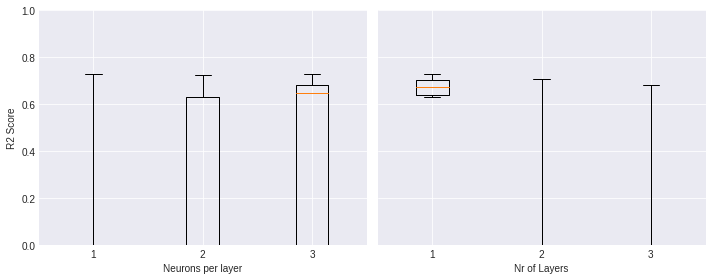

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
asdf = [hp_df[hp_df["neurons"] == i]["r2_score"] for i in [2, 4, 8]]
ax[0].boxplot(asdf);
ax[0].set_xlabel("Neurons per layer")
ax[0].set_ylabel("R2 Score")
ax[0].set_xticks([1,2,3], ["4", "8", "16"]);
asdf = [hp_df[hp_df["hidden_layers"] == i]["r2_score"] for i in [1, 2, 4]]
ax[1].boxplot(asdf);
ax[1].set_xlabel("Nr of Layers")
ax[1].set_xticks([1,2,3], ["1", "2", "4"]);
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../figs/WHR_TF_boxplot.pdf")

In [20]:
lrs = [0.0001, 0.001, 0.003]
epochs = [100, 200, 400, 800]
asdf = np.zeros((3,4))
for i in range(3):
    for j in range(4):
        asdf[i,j] = np.mean(hp_df[(hp_df["epochs"]==epochs[j]) & (hp_df["lr"]==lrs[i])]["r2_score"])

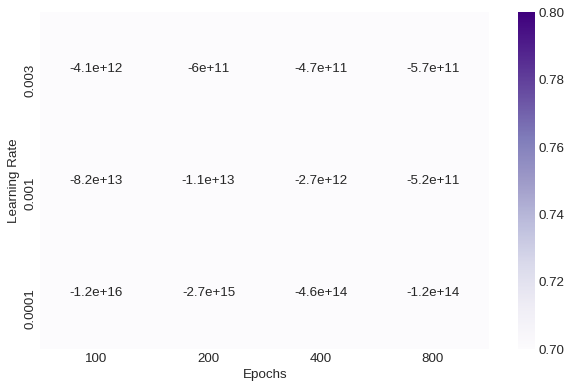

In [23]:
plt.figure(figsize=(8,5))
sns.heatmap(asdf, annot=True, xticklabels=epochs, yticklabels=lrs, vmin=0.7, vmax=0.8, cmap="Purples", square=True)
plt.ylim(0, 3)
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.tight_layout()
#plt.savefig("../figs/CC_TF_lr_epoch_heatmap", bbox_inches="tight")

# Casual NN fit

In [ ]:
#opti = optimizers.Adam(amsgrad=True)
#def nn_reg():
#    model = Sequential()
#    model.add(Dense(4, input_shape=(nr_params,), activation="relu", kernel_initializer='random_uniform'))
#    model.add(Dense(4, activation="relu", kernel_initializer='random_uniform'))
#    model.add(Dense(1, activation="linear", kernel_initializer='random_uniform'))
#    model.compile(optimizer=opti, loss="mean_squared_error",  metrics=["mse"])
#    return model
#nn_reg().summary()

In [ ]:
nr_averages = 100
r2_NN = np.zeros(1)
r22_NN = np.zeros(1)

for i in trange(nr_averages):
    reg = KerasRegressor(build_fn=nn_reg, batch_size=32, epochs=150, validation_split=0.0, verbose=0)

    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size=0.1)
    Scaler = preprocessing.StandardScaler()
    X_train_scaled = Scaler.fit_transform(X_train)
    X_test_scaled = Scaler.transform(X_test)
    
    history = reg.fit(X_train_scaled, Y_train)
    
    r2_NN[0] += r2_score(Y_test, reg.predict(X_test_scaled))
    r22_NN[0] += r2_score(Y_test, reg.predict(X_test_scaled))**2
    
    plt.plot(history.history["mse"])    
    
r2_NN /= nr_averages
r22_NN /= nr_averages

In [ ]:
r2_NN

In [ ]:
std_NN = np.sqrt(r22_NN - r2_NN**2); std_NN

In [ ]:
plt.scatter(Y_test, reg.predict(X_test_scaled))
plt.plot([3, 8], [3,8])